In [40]:
import flow_vis
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from skimage.io import imread

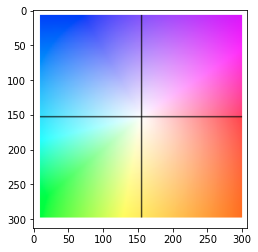

In [42]:
plt.imshow(imread("vector_coloring_data/Selection_022.png"))

In [32]:
flux = fits.getdata("vector_coloring_data/67-flux.fits")
background = fits.getdata("vector_coloring_data/67-background.fits")
center_of_mass = fits.getdata("vector_coloring_data/67-center_of_mass.fits")
claim_vectors = fits.getdata("vector_coloring_data/67-claim_vectors.fits")
claim_vectors.shape

(256, 256, 4, 5, 2)

In [10]:
def scale_image(data):

    ox = int(data.shape[0]/4)
    oy = int(data.shape[1]/4)
    nx = int(data.shape[0]/2)
    ny = int(data.shape[1]/2)

    s = np.std(data[ox:ox+nx,oy:oy+ny])
    m = np.mean(data[ox:ox+nx,oy:oy+ny])

    ret = (data-m)/s
    ret = np.log10((data-m)/s + 1.0e-6 - (data-m).min()/s)
    m = np.mean(ret)
    s = np.std(ret)

    ret[ret<m-0.5*s] = m-0.5*s
    ret[ret>m+2.0] = m+2.0
    ret = (ret - ret.min())/(ret.max()-ret.min())
    return ret

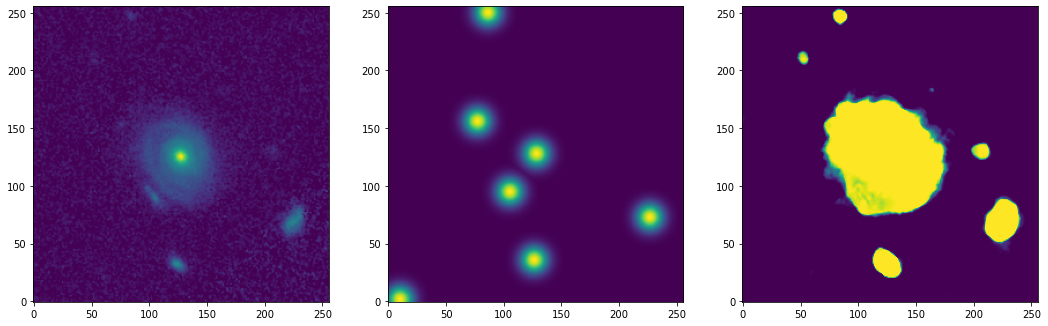

In [34]:
f, axes = plt.subplots(ncols=3, figsize=(18, 6))

arrs = [
    scale_image(flux[..., 0]), 
    center_of_mass[..., 0], 
    1 - background[..., 0]
]

for ax, arr in zip(axes.flat, arrs):
    ax.imshow(arr, origin="lower")

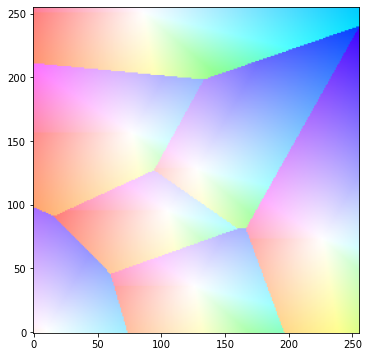

In [47]:
f, ax = plt.subplots(figsize=(6, 6))

ax.imshow(
    flow_vis.flow_to_color(
        claim_vectors[:, :, 0, 0, [1, 0]],
        convert_to_bgr=False
    ),
    origin="lower"
)

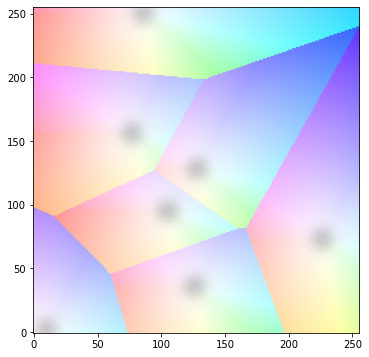

In [49]:
f, ax = plt.subplots(figsize=(6, 6))

ax.imshow(
    flow_vis.flow_to_color(
        claim_vectors[:, :, 0, 0, [1, 0]],
        convert_to_bgr=False
    ),
    origin="lower"
)
ax.imshow(
    center_of_mass[..., 0],
    cmap="Greys",
    origin="lower",
    alpha=0.2,
)

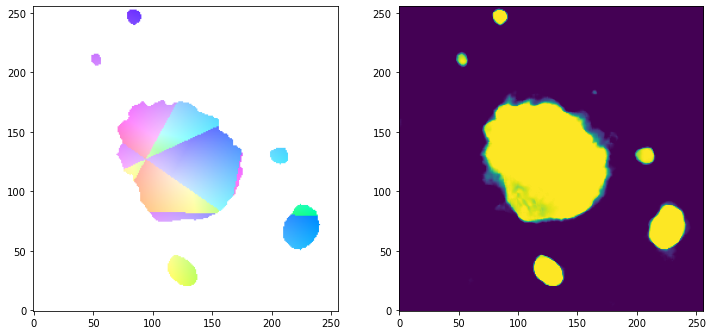

In [55]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.imshow(
    flow_vis.flow_to_color(
        claim_vectors[:, :, 0, 1, [1, 0]] * (background < 0.5) ,
        convert_to_bgr=False
    ),
    origin="lower"
)

ax2.imshow(1-background[..., 0], origin="lower")

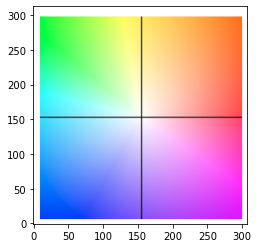

In [50]:
plt.imshow(imread("vector_coloring_data/Selection_022.png"), origin="lower")
